# 主旨
從yahoo finance(yfinance)抓取S&P500當前成分股「收盤」和「調整後的收盤」日報酬資料，再計算出效率前緣、MVP和切點投組

# 第一部分 - 蒙地卡羅
1. 從yahoo finance(yfinance)抓取S&P500當前成分股「調整後的收盤價」日報酬資料 (檔案類型為.csv)
    - 注意:要抓取的是當前S&P500當前成分股的資料(每日重複計算成分股)，而非抓取指數資料
    - 注意:同一檔股票，在不同國家(資料庫)的股票代碼可能不同，故股票代碼應與yfinance相同
2. 將資料存取成DataFrame，index為日期，column為股票代碼，value為調整後收盤日報酬率
3. 依據資料計算出「效率前緣」、「最小變異投資組合(MVP)」和「切點投組」
# 第二部分 - 公式解
1. 依據第一部份的目標-2所得資料，使用公式解出「效率前緣」、「MVP」和「切點投組」
2. 畫圖展示效率前緣、MVP、切點投組和資本配置線(CAL)

# 參考網站
1. yahoo finance : https://pypi.org/project/yfinance/0.2.19b4/
2. slickcharts : https://www.slickcharts.com/sp500
3. 如何從yahoo finance抓取S&P500當前成分股 : https://medium.com/ai%E8%82%A1%E4%BB%94/%E7%94%A8-python-%E6%89%93%E9%80%A0%E8%87%AA%E5%B7%B1%E7%9A%84%E8%82%A1%E5%B8%82%E8%B3%87%E6%96%99%E5%BA%AB-%E7%BE%8E%E8%82%A1%E7%AF%87-e3e896659fd6
4. 用於計算時間序列資料報酬率之方法-對數報酬率 : https://pyecontech.com/2020/11/03/%E9%87%8F%E5%8C%96%E6%8A%95%E8%B3%87%E5%9F%BA%E6%9C%AC%E5%8A%9F%E7%82%BA%E4%BB%80%E9%BA%BC%E5%B0%8D%E6%95%B8%E6%94%B6%E7%9B%8A%E7%8E%87%E5%9C%A8%E9%87%8F%E5%8C%96%E6%8A%95%E8%B3%87%E9%80%99%E9%BA%BC/
5. 計算效率前緣和MVP(蒙地卡羅) : https://ithelp.ithome.com.tw/articles/10250190
6. mvp公式 : https://faculty.washington.edu/ezivot/econ424/portfolioTheoryMatrix.pdf
7. 效率前緣公式 : https://gregorygundersen.com/blog/2022/01/09/geometry-efficient-frontier/
8. 切點投組公式 : https://bookdown.org/compfinezbook/introcompfinr/Efficient-portfolios-of.html

# 安裝所需套件

In [1]:
# pip install yfinance

# 導入套件

In [2]:
import numpy as np
import pandas as pd
import csv
import requests  
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines  # 用於自訂圖形中線段之圖示
from matplotlib.font_manager import fontManager  # 圖形字體套件
import yfinance as yf  # yahoo finance
import warnings

# 第一部分 - 蒙地卡羅

# 目標1 : 抓取S&P500當前成分股日報酬資料

## 1-1 從Slickcharts取得當前S&P500成分股名單(只有股票代碼)

由於yfinance只有每檔股票的資料，並沒有當前S&P500成分股名單，只好透過外部(Slickcharts)取得成分股名單，再從yfinance取得名單對應的資料

In [3]:
def web_crawler(url : str) -> list :
    
    '''
    功能 : 從slickcharts上爬取當前S&P500成分股名單
    輸入 : 
        url : slickcharts的網址，type = str
    輸出 : 
        Symbol_list : 當前S&P500成分股名單，type = list，dtype = str
    '''

    # 因為slickcharts會擋爬蟲，因此必須加這兩行程式碼
    # 來源:參考網站-3

    headers = {"User-Agent" : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36'}
    request = requests.get(url, headers = headers)

    # 將取得的S&P500成分股之股票代碼存入data_slickcharts中

    data_slickcharts = pd.read_html(request.text)[0]

    # 欄位『Symbol』就是股票代碼

    Symbol_list = data_slickcharts.Symbol

    # 用 replace 將符號進行替換 (因為slickcharts和yfinance的資料間隔符號不同，故將slickcharts的「.」改成yfinance的「-」

    Symbol_list = data_slickcharts.Symbol.apply(lambda x: x.replace('.', '-'))
    
    return Symbol_list

In [4]:
Symbol_list = web_crawler( url = 'https://www.slickcharts.com/sp500' )
Symbol_list

0       AAPL
1       MSFT
2       AMZN
3       NVDA
4      GOOGL
       ...  
499      AAP
500      LNC
501      NWL
502      NWS
503     FTRE
Name: Symbol, Length: 504, dtype: object

# 1-2 從yfinance取得當前S&P500成分股的資料並下載成.csv

- 先將yfinance會用到的語法整理如下
    - stock = yf.download('股票代碼')

In [5]:
c = yf.download('AAPL')
c.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-08-08,179.690002,180.270004,177.580002,179.800003,179.557526,67823000
2023-08-09,180.869995,180.929993,177.009995,178.190002,177.949707,60378500
2023-08-10,179.479996,180.750000,177.600006,177.970001,177.729996,54686900
2023-08-11,177.320007,178.619995,176.550003,177.789993,177.789993,51988100
2023-08-14,177.970001,179.690002,177.309998,179.460007,179.460007,43597400


In [6]:
def get_stock_price_to_csv( ) : 
    
    '''
    功能 : 抓取S&P500成分股資料並儲存成csv
    輸入 : 
        Symbol_list : S&P500當前成分股，type = list，dtype = str
    輸出 : 無
    
    '''
    # 爬取當前成分股名單
    
    Symbol_list = web_crawler( url = 'https://www.slickcharts.com/sp500' )
    
    # 抓取資料
    
    stock_price_list = []  # 因應pd.concat的需求，待會用於盛裝每檔股票的DataFrame ( 每檔股票有自己的DataFrame )
    failed_list = []  # 用於盛裝抓取失敗之股票

    for i in Symbol_list:  # 針對S&P500的每檔成分股分別做以下事情
    
        try :  # 為避免因過程中發生錯誤(如其中一檔股票抓取失敗)而導致整個迴圈停止，因此使用「try except」
            
            stock = yf.download(i)  # 將股票的data存入stock中       
            i_price = pd.DataFrame( stock['Adj Close'] )  # data中只擷取「調整收盤價」並儲存成DataFrame的資料型態
            i_price.rename( columns = { 'Adj Close' : i }, inplace = True )  # 改變column的名稱:將「調整收盤價」改為「股票代碼」
                                                                             # inplace = True:改變原來的DataFrame且不會回傳新的DF
            stock_price_list.append( i_price )  # 將股票的DataFrame新增至該list中，便於使用pd.concat時一次合併所有DataFrame
            time.sleep(1) # 避免被禁止爬蟲，休息1秒再抓下筆股票資料
        
        except : # 若在try區塊中發生錯誤則會進行此區塊之程式碼
            failed_list.append(i)  # 將抓取失敗的股票代碼新增至該list
            continue  # 繼續執行for迴圈
                    
    # 合併DataFrame # 
        
    stocks_adj_close_data = pd.concat( stock_price_list, axis = 1 )  # 一次合併所有DataFrame
                                                                     # axis = 1 : 合併column(水平合併)
                                                                     # 包含每個DataFrame的index (若其他DF在此index沒有資料則填NaN)
                                                                     # default = outer (聯集)
                
    print( '抓取失敗的股票有 :', failed_list )  # 回傳抓取失敗的股票集合
    
    # 將資料儲存成csv
    
    stocks_adj_close_data.to_csv( 'Adjusted closing prices of S&P 500 constituents.csv' )

In [7]:
get_stock_price_to_csv( )

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

# 目標2 : 建構S&P500成分股之調整後收盤日報酬資料
    1. 讀取先前儲存的csv檔案，並擷取資料範圍:2010~今天
    2. 建構日報酬資料
        注意 : 此處不使用「pct.change()」這個函數，因其計算報酬率方式為離散型，而此方法不符合報酬率加總原則
        因此 : 採用連續型報酬率計算方式「對數報酬率」(詳見參考網站-3)
        使用函數「.shift(x)」: 將整筆資料往前挪「x」天

## 2-1 讀取先前儲存的csv檔案，並擷取資料範圍:2010~今天

In [8]:
data = pd.read_csv( 'Adjusted closing prices of S&P 500 constituents.csv', index_col = 0 )  # 指定第0個column(日期)為index

In [9]:
data = data.loc['2010-01-04' : ]  # 擷取資料範圍「2010第一個交易日~今天」
data.head()

,AAPL,MSFT,AMZN,NVDA,GOOGL,META,GOOG,TSLA,BRK-B,UNH,...,SEE,MHK,RL,DXC,FOX,AAP,LNC,NWL,NWS,FTRE
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,6.487535,23.572371,6.6950,4.241149,15.684434,NaN,15.610239,NaN,66.220001,25.785114,...,17.340233,48.310001,65.530304,17.669445,NaN,36.574169,19.068478,10.044807,NaN,NaN
2010-01-05,6.498749,23.579981,6.7345,4.303082,15.615365,NaN,15.541497,NaN,66.540001,25.744226,...,17.159109,48.119999,68.101379,17.663321,NaN,36.356777,19.466358,9.985331,NaN,NaN
2010-01-06,6.395379,23.435274,6.6125,4.330607,15.221722,NaN,15.149715,NaN,66.199997,25.997744,...,16.828363,47.930000,67.587158,17.727587,NaN,36.673798,19.761084,10.163761,NaN,NaN
2010-01-07,6.383556,23.191555,6.5000,4.245736,14.867367,NaN,14.797037,NaN,66.459999,26.995451,...,17.001610,48.770000,68.888771,17.550098,NaN,36.664734,20.232809,10.454531,NaN,NaN
2010-01-08,6.425995,23.351500,6.6760,4.254912,15.065566,NaN,14.994298,NaN,66.440002,26.741930,...,17.072479,49.639999,69.394951,17.504190,NaN,36.809650,19.923237,10.421488,NaN,NaN


## 2-2 建構日報酬資料

In [10]:
return_data = data.pct_change()  # S&P500成分股日報酬率
return_data.head()

,AAPL,MSFT,AMZN,NVDA,GOOGL,META,GOOG,TSLA,BRK-B,UNH,...,SEE,MHK,RL,DXC,FOX,AAP,LNC,NWL,NWS,FTRE
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.001729,0.000323,0.005900,0.014603,-0.004404,NaN,-0.004404,NaN,0.004832,-0.001586,...,-0.010445,-0.003933,0.039235,-0.000347,NaN,-0.005944,0.020866,-0.005921,NaN,NaN
2010-01-06,-0.015906,-0.006137,-0.018116,0.006397,-0.025209,NaN,-0.025209,NaN,-0.005110,0.009848,...,-0.019275,-0.003948,-0.007551,0.003638,NaN,0.008720,0.015140,0.017869,NaN,NaN
2010-01-07,-0.001849,-0.010400,-0.017013,-0.019598,-0.023280,NaN,-0.023280,NaN,0.003928,0.038377,...,0.010295,0.017526,0.019258,-0.010012,NaN,-0.000247,0.023871,0.028608,NaN,NaN
2010-01-08,0.006648,0.006897,0.027077,0.002161,0.013331,NaN,0.013331,NaN,-0.000301,-0.009391,...,0.004168,0.017839,0.007348,-0.002616,NaN,0.003952,-0.015301,-0.003161,NaN,NaN


# 目標3 : 計算出效率前緣與最小變異投資組合(MVP)

## 做法說明
1. 計算在不同權數下之「投組報酬率」、「投組標準差」和「投組內各股票權數」
2. 畫散布圖 : x = 投組標準差，y = 投組報酬率
3. 計算在不同投組標準差下，投組報酬率最高之投組 (結果為一個效率集合)
4. 在散布圖中畫出效率前緣
5. 計算並在散布圖中標記出MVP和切點投組

## 3-1  計算在不同權數下之「投組報酬率」、「投組標準差」和「投組內各股票權數」
- 標準差為「報酬率」標準差，而非股價標準差

- 投組標準差做法說明 

In [11]:
def calculate_protfolios( data : pd.DataFrame, stocks_nums : int, port_nums : int ) -> pd.DataFrame  :
    
    '''
    功能 : 計算各個投組之報酬率和標準差，以及各投組內每檔股票之權數
    輸入 : 
        1. data : 股票「報酬率」的資料(即2-2所得結果)，type = pd.DataFrame
        2. stocks_nums : 用於建構投組的股票數目，dtype = int (數目上限為return_data的股數，下限為2，
                                                               股票依照return_data的columns順序選取)
                         * 若要包含data所有股數，則輸入「stocks_nums = len(Symbol_list)」
        3. port_nums : 要計算的投組數目
    輸出 : portfolios : 所有投組( columns={各個投組的報酬率、標準差，各投組內每檔股票之權數} )，type : pd.DataFrame 
    '''
    
# 選取股票 # 

    data = data.iloc[ : , : stocks_nums ]  # 將股數改為前stocks_nums檔
    
# 計算S&P成分股個別報酬率、標準差以及共變異數矩陣 #
    
    return_mean = data.mean()  # 日報酬率，type( return_mean ) = pd.series
    return_std = data.std()  # 標準差，tpye( return_std ) = pd.series
    cov_matrix = data.cov()  # 共變異數矩陣，type( cov_matrix ) = pd.dataframe
    
# 建構投組 #

    # 設定參數 #
    
    port_ret = []  # 盛裝各個投組之報酬率 
    port_std = []  # 盛裝各個投組之標準差 
    port_weights = []  # 盛裝各個投組權數 ( 其中每一個元素皆為list，因要包含任一投組中各個股票之權數 )
    
    # 開始計算 #
    
    for i in range( port_nums ) :  # 針對每個投組做以下事情
   
        # 隨機產生權數 #

        weights = np.random.random( stocks_nums )  # 隨機產生stocks_nums個介於0~1之數字
                                                   # type( weights ) = np.ndarray
                                                   # len( weights ) = stocks_nums
        weights = weights / np.sum( weights )  # 一次計算每檔股票之權數                
        port_weights.append( weights )  # 將所有股票之權數添加至list中

        # 計算投組報酬率 #

        expected_return = np.dot( return_mean, weights )  # 計算投組期望報酬率
        annual_return = expected_return*250  # 年化投組期望報酬率
        port_ret.append( annual_return )  # 將年化投組期望報酬率添加至list中

        # 計算投組標準差 #

        var = cov_matrix.mul( weights, axis = 0 ).mul( weights , axis = 1 ).sum().sum()  # 說明見上面三個區塊
        annual_var = var*250  # 年化變異數 (原資料頻率為日資料，一年交易日以250天計算) 
        annual_std = np.sqrt( annual_var )  # 年化標準差
        port_std.append( annual_std )  # 將投組標準差盛裝進該list中
    
    # 建構DataFram #
    
        # 報酬、標準差 #
    
    port_data = { 'Returns' : port_ret, 'Standard Deviation' : port_std }

        # 投組內每個股票權數 # 

    for index, symbol in enumerate( Symbol_list[ : stocks_nums] ) : 
                                                     # Symbol_list[ : stocks_nums] : 取Symbol_list中前Symbol_list檔的股票
                                                     # enumerate(Symbol_list):將Symbol_list傳回含index之list
                                                     # 該list中每個元素有兩個參數 (index, value = symbol)
                                                     # 故此迴圈針對enumerate後的股票代碼做以下事情
        weight_temp = []  # 權數暫存list
        for i in port_weights :  # 針對投組權數list中每個元素 (內部每個元素皆為list)
            weight_temp.append( i[index] )  # 依據股票代碼(index對應之value)從各個投組權數list中抽取該股票之權數並存入weight_temp中
                                            # ex:將所有投組權術內屬於AAPL的權數抽離出來並存入weight_temp中
        port_data[ symbol + ' weight'] = weight_temp  # 在port_data新增一欄位，名稱「股票代碼+weight」，資料為weight_temp

    portfolios = pd.DataFrame( port_data )
    
    return portfolios

In [12]:
portfolios = calculate_protfolios( data = return_data, stocks_nums = len(Symbol_list), port_nums = 2000 )
portfolios.head()

,Returns,Standard Deviation,AAPL weight,MSFT weight,AMZN weight,NVDA weight,GOOGL weight,META weight,GOOG weight,TSLA weight,...,SEE weight,MHK weight,RL weight,DXC weight,FOX weight,AAP weight,LNC weight,NWL weight,NWS weight,FTRE weight
0,0.176749,0.186956,0.001222,0.002424,0.002357,0.003319,0.003910,0.000706,0.001393,0.000540,...,0.003790,0.003505,0.000717,0.002749,0.002328,0.000908,0.002384,0.003821,0.003430,0.001880
1,0.174749,0.190426,0.000078,0.003054,0.000360,0.002274,0.001316,0.002128,0.001414,0.001517,...,0.003451,0.000460,0.002789,0.000225,0.001542,0.000163,0.003005,0.003727,0.002779,0.001504
2,0.176328,0.187108,0.000318,0.000512,0.001358,0.002508,0.001842,0.001290,0.001140,0.003547,...,0.003631,0.003429,0.001143,0.000872,0.002716,0.001274,0.002103,0.002889,0.003216,0.003187
3,0.173667,0.188155,0.001386,0.000784,0.002045,0.001443,0.002766,0.003412,0.003167,0.001330,...,0.001140,0.003386,0.002273,0.000389,0.000041,0.001623,0.003477,0.000555,0.003188,0.003756
4,0.174087,0.187433,0.003801,0.003895,0.002771,0.001904,0.000265,0.000126,0.003355,0.003212,...,0.002211,0.003097,0.001866,0.001869,0.000105,0.000074,0.002532,0.002167,0.000641,0.003562


## 3-2 畫散布圖(圖-1) 

Text(0, 0.5, 'Returns')

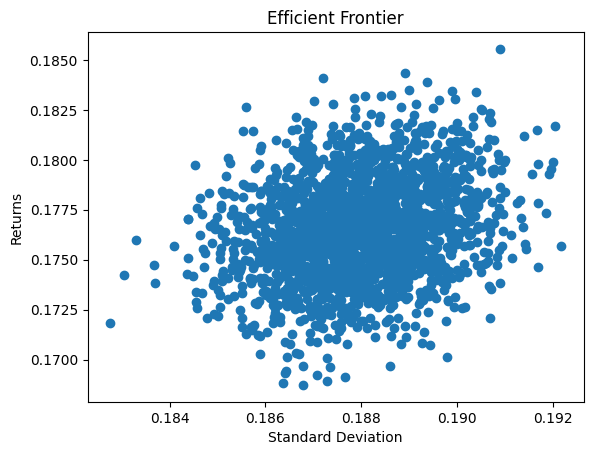

In [13]:
plt.title( 'Efficient Frontier' )  # 設定圖形標題
plt.scatter( x = portfolios['Standard Deviation'] , y = portfolios['Returns'] )  # x=投組標準差, y=投組報酬率
plt.xlabel( 'Standard Deviation' )  # 設定x軸名稱
plt.ylabel( 'Returns' )  # 設定y軸名稱

### 釐清3-2(圖-1)為何看不出效率前緣的樣貌 ( 下圖為 圖-2 )
- 推測 : 參考網站以2檔股票示範，而此處包含S&P500所有成分股(約500股)，故差異原因推測為股票數量過多
- 驗證 : 將股票數量改成3檔，投組數量仍維持2000驗證推測

Text(0, 0.5, 'Returns')

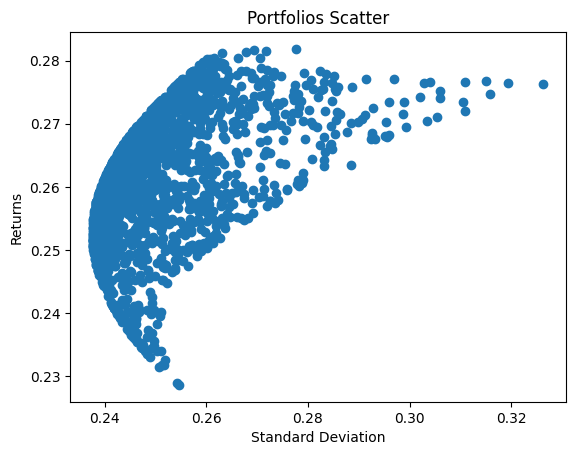

In [14]:
portfolios = calculate_protfolios( data = return_data, stocks_nums = 3, port_nums = 2000 )

plt.title( 'Portfolios Scatter' )  
plt.scatter( x = portfolios['Standard Deviation'] , y = portfolios['Returns'] ) 
plt.xlabel( 'Standard Deviation' )  
plt.ylabel( 'Returns' )  

- 驗證結果 : 在固定參數「投組數量=2000」下，將參數「股數=500(約)」改為「股數=3」後即能呈現出效率前緣之樣貌
- 推測 : 上述變化原因可能為「股數=500(約)」的自由度太大(約499)，潛在可能投組太多，而灑點數量(樣本數)「投組數量=2000」相對太少，故無法找出效率前緣，而「股數=3」的自由度僅有2，潛在可能投組雖多，但相對自由度499而言，「投組數量=2000」足夠多，故可以找到效率前緣
- 驗證 : 下方更改另個參數「投組數量」，固定「股數=3」下，分別將「投組數量」改成「2000」、「500」、「50」、「10」，驗證投組數量(灑點次數、樣本數)之影響

In [15]:
def new_calculate_protfolios( data : pd.DataFrame, stocks_nums : int, port_nums : int ) -> list :
    
    '''
    功能 : 刪除原函數建構DataFrame之程式碼以加快運算速度 ( 只在有變動地方寫註解 )
    '''
    data = data.iloc[ : , : stocks_nums ]  
    return_mean = data.mean() 
    return_std = data.std()  
    cov_matrix = data.cov()
    port_ret = []  
    port_std = []  
    port_weights = [] 
    for i in range( port_nums ) : 
        weights = np.random.random( stocks_nums )  
        weights = weights / np.sum( weights )                  
        port_weights.append( weights )  
        expected_return = np.dot( return_mean, weights )  
        annual_return = expected_return*250  
        port_ret.append( annual_return )  
        var = cov_matrix.mul( weights, axis = 0 ).mul( weights , axis = 1 ).sum().sum()  
        annual_var = var*250  
        annual_std = np.sqrt( annual_var )  
        port_std.append( annual_std ) 
    
    # 刪除原函數以下建構DataFrame的內容 #
    
    # 回傳各個投組之報酬率和標準差 # 
    
    return port_ret, port_std

- 畫圖展示驗證過程

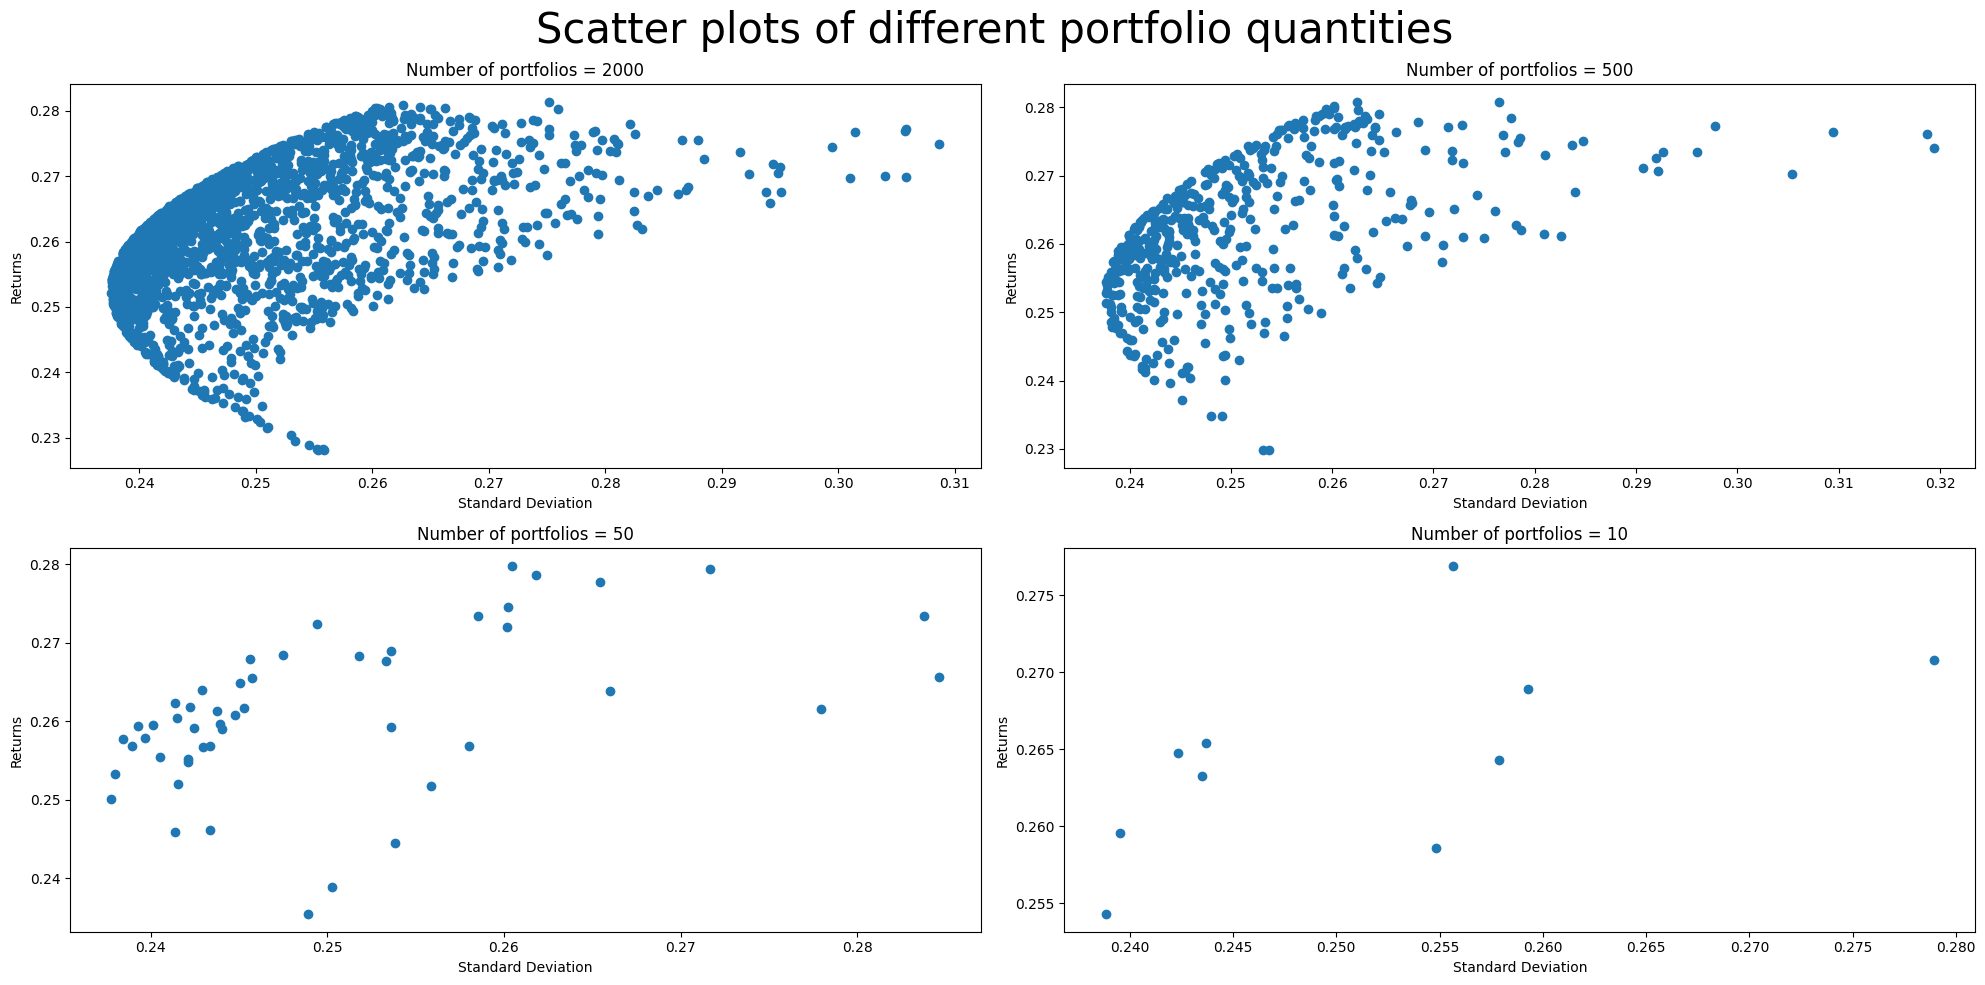

In [16]:
# 使用新函數計算在不同投組數量設定之結果 #

port_ret_2000, port_std_2000 = new_calculate_protfolios( data = return_data, stocks_nums = 3, port_nums = 2000 )  # 投組數量=2000
port_ret_500, port_std_500 = new_calculate_protfolios( data = return_data, stocks_nums = 3, port_nums = 500 )  # 投組數量=500
port_ret_50, port_std_50 = new_calculate_protfolios( data = return_data, stocks_nums = 3, port_nums = 50 )  # 投組數量=50
port_ret_10, port_std_10 = new_calculate_protfolios( data = return_data, stocks_nums = 3, port_nums = 10 )  # 投組數量=10
 
# 畫圖展示 # 

#  設定全圖參數

fig = plt.figure( figsize=(20,10) )  # 全圖大小
fig.suptitle('Scatter plots of different portfolio quantities', fontsize = 30)  # 全圖總標題 / 設定字體大小=30

# 設定子圖參數(繪製2*2的子圖)

    # 第一個子圖(左上)，展示投組數量=2000

plt.subplot(221)  # 前兩個代碼「22」表共有2*2個子圖，第三個代碼「1」表第一個子圖
x = port_std_2000  # 投組數量=2000下投組標準差
y = port_ret_2000  # 投組數量=2000下投組報酬率
plt.scatter(x, y)
plt.title('Number of portfolios = 2000')  # 子圖標題
plt.xlabel( 'Standard Deviation' )  # 子圖x軸名稱
plt.ylabel( 'Returns' )  # 子圖y軸名稱

    # 第二個子圖(右上)，展示投組數量=500

plt.subplot(222)  # 前兩個代碼「22」表共有2*2個子圖，第三個代碼「2」表第二個子圖
x = port_std_500  # 投組數量=500下投組標準差
y = port_ret_500  # 投組數量=500下投組報酬率
plt.scatter(x, y)
plt.title('Number of portfolios = 500')  # 子圖標題
plt.xlabel( 'Standard Deviation' )  # 子圖x軸名稱  
plt.ylabel( 'Returns' )  # 子圖y軸名稱 

    # 第三個子圖(左下)，展示投組數量=50

plt.subplot(223)  # 前兩個代碼「22」表共有2*2個子圖，第三個代碼「3」表第三個子圖
x = port_std_50  # 投組數量=50下投組標準差
y = port_ret_50  # 投組數量=50下投組報酬率
plt.scatter(x, y)
plt.title('Number of portfolios = 50')  # 子圖標題
plt.xlabel( 'Standard Deviation' )  # 子圖x軸名稱  
plt.ylabel( 'Returns' )  # 子圖y軸名稱 

    # 第四個子圖(右下)，展示投組數量=10

plt.subplot(224)  # 前兩個代碼「22」表共有2*2個子圖，第三個代碼「4」表第四個子圖
x = port_std_10  # 投組數量=10下投組標準差
y = port_ret_10  # 投組數量=10下投組報酬率
plt.scatter(x, y)
plt.title('Number of portfolios = 10')  # 子圖標題
plt.xlabel( 'Standard Deviation' )  # 子圖x軸名稱  
plt.ylabel( 'Returns' )  # 子圖y軸名稱 

fig.tight_layout()  # 使子圖標題不會重疊

- 驗證結果 : 由上面四個圖可得知，在固定參數「股數=3」下，隨著參數「投組數量」減少，效率前緣的樣貌愈模糊
- 結論 : 股數愈多(自由度愈大)，要找出效率前緣所需投組數量(灑點次數、樣本數)愈多。在「股數=2000」下，「投組數量=2000」太少；在「股數=3」下，「投組數量=2000」足夠

## 3-3  找出效率集合
- 由於「股數=2000」下要找出效率前緣所需「投組數量」過多，超過本電腦之計算能力
- 故後續內容將使用「圖-2」的參數設定，設定如下:
    1. 股數=3
    2. 投組數量=2000

In [17]:
def Efficient_Frontier( data : pd.DataFrame, stocks_nums : int, port_nums : int  ) -> pd.DataFrame :
    
    '''
    功能 : 計算效率集合
    輸入 : 
        1. data : 股票「報酬率」的資料(即2-2所得結果)，type = pd.DataFrame
        2. stocks_nums : 用於建構投組的股票數目，type = int (數目上限為return_data的股數，下限為2，
                                                           股票依照return_data的columns順序選取)
                        * 若要包含data所有股數，則輸入「stocks_nums = len(Symbol_list)」
        3. port_nums : 要計算的投組數目，type = int
    輸出 : 
        1. portfolios : 所有投組，type = pd.DataFrame
        2. eff_set : 效率集合，type = pd.DataFrame
    '''
    
    # 建構投組 #

    portfolios = calculate_protfolios( data = data, stocks_nums = stocks_nums, port_nums = port_nums )

    # 計算MVP #

    mvp = portfolios[ portfolios['Standard Deviation'] == portfolios['Standard Deviation'].min() ]  
        # MVP投組，type = pd.dataFrame
        # 找出所有投組中標準差最小的那個row
    mvp_ret = mvp['Returns'].values[0]  # MVP之報酬率，type = np.float64
                                        # type( mvp['Returns'].values ) = np.ndarray且只有一個數值
                                        # 故加上[0]將數值取出來，此時type將改成np.float64
            
    # 計算效率集合 #
    
    eff_set_list = [ mvp ]  # 效率集合list，盛裝每個效率投組，dtype = pd.DataFrame
                            # 先將MVP加入效率集合list中

    for i in range(0,100) :  # 將標準差分成100等分，對每個區間內所有投組做以下事情
        
        lower_boundary = np.percentile( portfolios['Standard Deviation'], i )  # 區間下界
        upper_boundary = np.percentile( portfolios['Standard Deviation'], i+1 )  # 區間上界

        try :  # 若try區塊中發生錯誤則執行except區塊之程式碼
               # 用意 : 因上述切分方式不保證一定有投組包含在該區間內，故加入「try - except」避免因區間內沒有投組抓不到而報錯

            # 找出落在該區間中的所有投組 #

            interval_set = portfolios[ ( portfolios['Standard Deviation'] >= lower_boundary ) &  # 標準差大於等於區間下界
                                       ( portfolios['Standard Deviation'] < upper_boundary )     # 標準差小於區間下界
                                     ]                                                  # 符合上面兩個條件之投組即落在該區間中
                                                                                        # 將區間中所有投組存入interval_set
            # 找出區間中報酬率最大之投組 #

            interval_max_ret_port = interval_set[ interval_set['Returns'] == interval_set['Returns'].max() ]
                # type( interval_max_ret_port ) = pd.DataFrmae

            # 取出該投組之報酬率 #

            interval_max_ret = interval_max_ret_port['Returns'].values[0]  
                # type( interval_max_ret ) = np.float64

            # 確認該投組報酬率是否大於MVP #

            if interval_max_ret > mvp_ret :              
                eff_set_list.append( interval_max_ret_port )                                    

        except :  # 若執行try區塊程式碼時發生錯誤則執行此區塊程式碼
            pass  # 跳過，進行下一迴圈
        
    # 合併DataFrame #
    
    eff_set = pd.concat( eff_set_list, axis = 0 )  # 將eff_set_list中所有DataFrame一次合併，axis=0表垂直合併(row) 
    
    # 回傳 # 
    
    return portfolios, eff_set

In [18]:
# 計算效率集合 
portfolios, eff_set = Efficient_Frontier( data = return_data, stocks_nums = 3, port_nums = 2000 )
eff_set.head()

,Returns,Standard Deviation,AAPL weight,MSFT weight,AMZN weight
1257,0.252513,0.237602,0.348447,0.507919,0.143634
1187,0.254541,0.237751,0.355043,0.469316,0.175641
588,0.255102,0.237805,0.380429,0.461355,0.158216
807,0.256201,0.238093,0.406082,0.442970,0.150948
1417,0.257008,0.238243,0.382667,0.424589,0.192744


## 3-4 在散布圖中畫出效率前緣

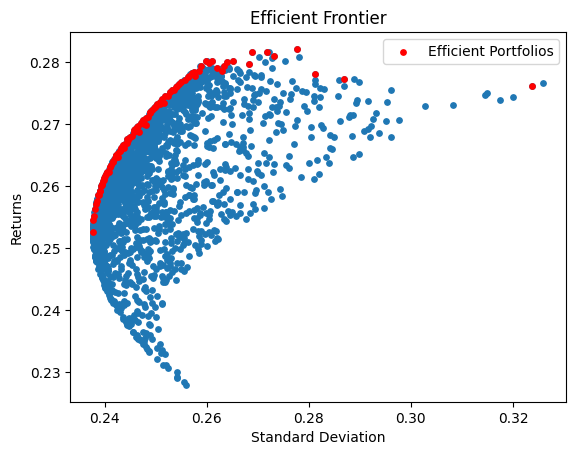

In [19]:
plt.title( 'Efficient Frontier' )  # 圖形標題
plot_port = plt.scatter( x = portfolios['Standard Deviation'] , y = portfolios['Returns'], s = 15 ) # 散布圖，點大小=15
plot_eff_set = plt.scatter( x = eff_set['Standard Deviation'] , y = eff_set['Returns'], c = 'r', s = 15 )  # 效率前緣，點大小=15
plt.xlabel( 'Standard Deviation' )  # x軸名稱
plt.ylabel( 'Returns' )  # y軸名稱
plt.legend( [plot_eff_set], ['Efficient Portfolios'])  # 圖例

- 上圖有些點落在效率前緣下方之原因 : 灑點次數不足(不夠密集)，使得可能出現無法灑到某標準差下最大報酬率之投組

## 3-5 計算並在散布圖中標記出MVP和切點投組

In [20]:
def calculate_mvp_tangency_port( data : pd.DataFrame, stocks_nums : int, port_nums : int, rf : float )  :
    
    '''
    功能 : 計算MVP和切點投組
    輸入 : 
        1. data : 股票「報酬率」的資料(即2-2所得結果)，type = pd.DataFrame
        2. stocks_nums : 用於建構投組的股票數目，type = int (數目上限為return_data的股數，下限為2，
                                                            股票依照return_data的columns順序選取)
                        * 若要包含data所有股數，則輸入「stocks_nums = len(Symbol_list)」
        3. port_nums : 要計算的投組數目，type = int
        4. rf : 無風險利率，type = float
    輸出 : 
        1. mvp : 最小變異投組，type = pd.DataFrame
        2. tangency_port : 切點投組，type = pd.DataFrame
    '''
    
    # 計算效率集合 #
    
    portfolios, eff_set = Efficient_Frontier( data = data, stocks_nums = stocks_nums, port_nums = 2000 )
    
    # 計算MVP #

    mvp = pd.DataFrame( eff_set.iloc[0] ).T  # 由函數「Efficient_Frontier()」中的「# 設定找效率集合所需參數 #」可知
                                             # eff_set的第一筆資料即為MVP
                                             # 又因「.iloc」會將資料由pd.DataFrame改為pd.Series且進行轉置
                                             # 故要反向操作，將資料由pd.Series改回pd.DataFrame並進行轉置
                
    # 計算切點投組 #
    
        # 在 eff_set 中新增一個column「Sharpe ratio」 #
        
    eff_set['Sharpe ratio'] = ( eff_set['Returns'] - rf ) / eff_set['Standard Deviation']
    
        # 切點投組 = 效率前緣(集合)上Sharpe ratio最大之投組
        
    tangency_port = eff_set[ eff_set['Sharpe ratio'] == eff_set['Sharpe ratio'].max() ]
    
    # 回傳 #
    
    return mvp, tangency_port

In [21]:
# 計算mvp和切點投組
mvp, tangency_port = calculate_mvp_tangency_port( data = return_data, stocks_nums = 3, port_nums = 2000, rf = 0.05 )

- 畫圖展示

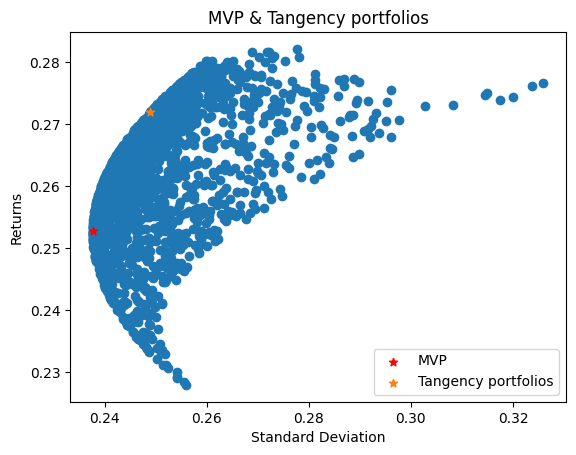

In [22]:
plt.title( 'MVP & Tangency portfolios' )  # 圖形標題
plt.scatter( x = portfolios['Standard Deviation'] , y = portfolios['Returns'] ) # 散布圖
mvp_plot = plt.scatter( x = mvp['Standard Deviation'] , y = mvp['Returns'], c = 'r', marker='*')  # MVP
tangency_port_plot = plt.scatter( x = tangency_port['Standard Deviation'] , y = tangency_port['Returns'], marker='*')  # 切點投組 
plt.xlabel( 'Standard Deviation' )  # x軸名稱
plt.ylabel( 'Returns' )  # y軸名稱
plt.legend( [mvp_plot, tangency_port_plot], ['MVP', 'Tangency portfolios'] )  # 圖例

# 第二部分 - 公式解

## 目標1 : 依據第一部份的目標-2所得資料，使用公式解出「效率前緣」、「MVP」和「切點投組」
- 使用公式解時，不需像第一部份那樣受限於電腦算力而減少股數，故後續分析股數為「所有」的S&P500成分股

### 1-1  計算MVP

In [23]:
return_data.head()

,AAPL,MSFT,AMZN,NVDA,GOOGL,META,GOOG,TSLA,BRK-B,UNH,...,SEE,MHK,RL,DXC,FOX,AAP,LNC,NWL,NWS,FTRE
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.001729,0.000323,0.005900,0.014603,-0.004404,NaN,-0.004404,NaN,0.004832,-0.001586,...,-0.010445,-0.003933,0.039235,-0.000347,NaN,-0.005944,0.020866,-0.005921,NaN,NaN
2010-01-06,-0.015906,-0.006137,-0.018116,0.006397,-0.025209,NaN,-0.025209,NaN,-0.005110,0.009848,...,-0.019275,-0.003948,-0.007551,0.003638,NaN,0.008720,0.015140,0.017869,NaN,NaN
2010-01-07,-0.001849,-0.010400,-0.017013,-0.019598,-0.023280,NaN,-0.023280,NaN,0.003928,0.038377,...,0.010295,0.017526,0.019258,-0.010012,NaN,-0.000247,0.023871,0.028608,NaN,NaN
2010-01-08,0.006648,0.006897,0.027077,0.002161,0.013331,NaN,0.013331,NaN,-0.000301,-0.009391,...,0.004168,0.017839,0.007348,-0.002616,NaN,0.003952,-0.015301,-0.003161,NaN,NaN


In [24]:
def calc_mvp_formula( data : pd.DataFrame ) :
    
    '''
    功能 : 計算MVP『公式解』的權數、報酬率、標準差
    輸入 : data : 股票「日報酬率」的資料，type = pd.DataFrame
    輸出 : 
        1. W : MVP權數，type = pd.DataFrame
        2. ret : MVP報酬率，type = np.float64
        3. std : MVP標準差，type = np.float64
    '''
    
    # 參數設定 # 
    
        # 所有股票之平均報酬率向量 # 

    average_ret = np.array( data.mean() )  # 為了後續矩陣運算，將type = pd.Series -> np.ndarray

        # 所有股票之共變異數矩陣 # 

    cov_matrix = np.array( data.cov() )  # 為了後續矩陣運算，將type = pd.DataFrame -> np.ndarray

        # 共變異數『逆』矩陣 #

    inverse_cov_matrix = np.linalg.inv( cov_matrix )  # 計算逆矩陣，type = pd.DataFrame

        # 元素全為1的矩陣 (n*1) # 

    matrix_1 = np.ones( ( len(average_ret), 1 ) )  # type = np.ndarray
    
    # 計算MVP的權數向量 #

    W = inverse_cov_matrix @ matrix_1 @ np.linalg.inv( matrix_1.T @ inverse_cov_matrix @ matrix_1 )  # MVP的權數向量
                                                                                                     # type = np.ndarray
    W = pd.DataFrame( W )  # 將 type = np.ndarray -> pd.DataFrame
    W.rename( columns = { 0 : 'weight' }, inplace = True )  # 改變columns名稱，並在原來的dataframe進行修改

    # 計算MVP報酬率 #
    
    ret = average_ret.T @ W   # 計算MVP投組報酬率，type = pd.Series
    ret = ret.values[0]*250  # 取出Series的values並年化，dtype = np.float64

     # 計算MVP標準差 #
    
    var = W.T @ cov_matrix @ W  # MVP投組變異數，type = pd.DataFrame
    annual_var = var*250  # 年化變異數
    std_df = np.sqrt( annual_var )  # MVP投組標準差，type = pd.DataFrame
    std = std_df.values[0][0]  # 取出DataFrame的values，dtype = np.float64
    
    # 回傳 #
    
    return W, ret, std  # 回傳 1. MVP公式解的權數
                        #      2. MVP公式解的報酬率
                        #      3. MVP公式解的標準差

### 1-2 計算切點投組

In [25]:
def calc_tangency_port_formula( data : pd.DataFrame, rf : float ) : 
    
    '''
    功能 : 計算切點投組公式解之權數、報酬率、標準差
    輸入 : 
        1. data : 股票「日報酬率」的資料，type = pd.DataFrame
        2. rf : 無風險利率，type = float，rf >= 0
    輸出 : 
        1. W : 切點投組權數，type = pd.DataFrame
        2. ret : 切點投組報酬率，type = np.float64
        3. std : 切點投組標準差，type = np.float64
    '''
    
    # 參數設定 #
    
        # 資產報酬率向量(n*1) # 
        
    annual_average_ret = np.array( data.mean()*250 )  # 所有股票之年化平均報酬率  
                                                      # 為了後續矩陣運算，將type = pd.Series -> np.ndarray
                                                      # 矩陣size = (n,)，其中 n = 股票數目
    R = annual_average_ret.reshape( len(annual_average_ret), 1)  # 將size改成(n,1)以利後續運算

        # 所有股票之共變異數矩陣 # 

    cov_matrix = np.array( data.cov() )  # 為了後續矩陣運算，將type = pd.DataFrame -> np.ndarray

        # 共變異數『逆』矩陣 #

    inverse_cov_matrix = np.linalg.inv( cov_matrix )  # 計算逆矩陣，type = np.ndarray

        # 元素全為1的矩陣 (n*1) # 

    matrix_1 = np.ones( ( len(annual_average_ret), 1 ) )  # type = np.ndarray
    
        # 風險溢酬矩陣 # 
    
    rf_df = rf*matrix_1  # 無風險利率矩陣，type = np.ndarray，size = (n,1)
    premium = R - rf_df  # 風險溢酬矩陣，type = np.ndarray，size = (n,1)
        
    # 計算切點投組權數向量 #
    
    temp = matrix_1.T @ inverse_cov_matrix @ premium  # 公式的分母
    W = inverse_cov_matrix @ premium @ np.linalg.inv( temp )  # 切點投組權數向量，type = np.ndarray
    W = pd.DataFrame( W )  # 將 type = np.ndarray -> pd.DataFrame
    W.rename( columns = { 0 : 'weight' }, inplace = True )  # 改變columns名稱，並在原來的dataframe進行修改
    
    # 計算切點投組報酬率 #
    
    ret = R.T @ W  # 切點投組報酬率，type = pd.DataFrame (1*1)
    ret = ret.values[0][0]  # 將值從dataframe中取出，type = np.float64
    
    # 計算切點投組標準差 #
    
    var = W.T @ cov_matrix @ W  # 切點投組變異數，type = pd.DataFrame (1*1)
    var = var.values[0][0]  # 將值從dataframe中取出，type = np.float64
    annual_var = var*250  # 年化變異數
    std = np.sqrt( annual_var )  # 切點投組標準差
    
    # 回傳 # 
    
    return W, ret, std  # 回傳 1. 切點投組公式解的權數
                        #      2. 切點投組公式解的報酬率
                        #      3. 切點投組公式解的標準差

### 1-3  計算出效率前緣

In [26]:
def calc_eff_port_formula( data : pd.DataFrame, target_ret : float ) : 
    
    '''
    功能 : 給定某一目標報酬率下，計算效率投組之權數、標準差
    輸入 : 
        1. data : 股票「日報酬率」的資料，type = pd.DataFrame
        2. target_ret : 目標報酬率
    輸出 : 
        1. W : 效率投組之權數向量，type = np.ndarray
        2. target_ret : 效率投組之報酬率 = 目標報酬率(事先給定)，type = type = np.float64
        3. std : 效率投組之標準差，type = type = np.float64
    '''
    
    # 參數設定 #
    
         # 資產報酬率向量(n*1) # 
    annual_average_ret = np.array( data.mean()*250 )  # 所有股票之年化平均報酬率 # 
                                                      # 為了後續矩陣運算，將type = pd.Series -> np.ndarray
                                                      # 矩陣size = (n,)，其中n = 股票數目
    r = np.array( annual_average_ret ).reshape( len(annual_average_ret), 1)  # 資產報酬率向量(n*1)
    
        # 所有股票之共變異數矩陣 # 

    cov_matrix = np.array( data.cov() )  # 為了後續矩陣運算，將type = pd.DataFrame -> np.ndarray

        # 共變異數『逆』矩陣 #

    inverse_cov_matrix = np.linalg.inv( cov_matrix )  # 計算逆矩陣，type = np.ndarray

        # 元素全為1的矩陣 (n*1) # 

    matrix_1 = np.ones( ( len(annual_average_ret), 1 ) )  # type = np.ndarray
    
        # R矩陣 #
        
    R = np.hstack( (r, matrix_1 ) )  # np.hstack() : 水平合併矩陣
    
        # M 相關矩陣 #
        
    M = R.T @ inverse_cov_matrix @ R  # M矩陣 
    M_inverse = np.linalg.inv(M)  # M的逆矩陣 
    
    # 計算效率投組之權數 #
    
    U = np.vstack( (target_ret,1) )  # 參數「矩陣U(2*1)」，type = np.ndarray
    W = inverse_cov_matrix @ R @ M_inverse @ U  # 效率投組之權數向量，type = np.ndarray
    
    # 計算效率投組之標準差 # 
    
    var = W.T @ cov_matrix @ W  # 效率投組之變異數，# type = np.ndarray
    annual_var = var*250  # 年化變異數
    std = np.sqrt( annual_var )  # 效率投組之標準差，# type = np.ndarray
    std = std[0][0]  # 將value從array中取出，type = np.float64
    
    # 回傳 #
    
    return W, target_ret, std

In [27]:
def calc_eff_font_formula( data : pd.DataFrame, ret_min : float, ret_max, port_nums : int )  :
    
    '''
    功能 : 給定目標「報酬率在某一區間內」和「欲計算效率投組之數量」下，計算「所有」效率投組之權數、標準差。
            將輸出「ret_eff_list」和「std_eff_list」作圖即可得效率前緣
    輸入 : 
        1. data : 股票「日報酬率」的資料，type = pd.DataFrame
        2. ret_min : 目標年化報酬率區間下界(最小值)
        3. ret_max : 目標年化報酬率區間下界(最大值)
        4. port_nums : 欲計算效率投組之數量
    輸出 : 
        1. w_eff_list : 包含所有效率投組之權數的list，dtype = np.float64
        2. ret_eff_list : 包含所有效率投組之報酬率的list，dtype = np.float64
        3. std_eff_list : 包含所有效率投組之標準差的list，dtype = np.float64
    '''
    # 建立空list # 
    
    w_eff_list = []  # 後面用於承裝給定不同報酬率下之效率投組權數
    ret_eff_list = []  # 後面用於承裝事先給定的不同報酬率
    std_eff_list = []  # 後面用於承裝給定不同報酬率下之效率投組標準差

    # 計算不同報酬率下之效率投組 #
    
    step = ( ret_max - ret_min ) / port_nums  # 下方迴圈之間隔
    for target_ret in np.arange(ret_min, ret_max, step) :  # target_ret從ret_min到ret_max，分別代入函數 
        w_eff, ret_eff, std_eff = calc_eff_port_formula( data = data, target_ret = target_ret)
        w_eff_list.append(w_eff)  # 將函數計算結果裝進list中
        ret_eff_list.append(ret_eff)  # 將函數計算結果裝進list中(報酬率為事先給定)
        std_eff_list.append(std_eff)  # 將函數計算結果裝進list中
        
    return w_eff_list, ret_eff_list, std_eff_list

## 目標2 : 畫圖展示效率前緣、MVP、切點投組和資本配置線(CAL)

Text(0, 0.5, 'Returns')

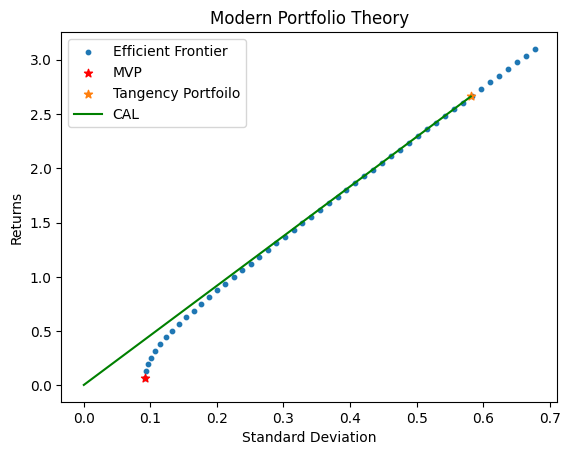

In [28]:
# MVP # 

mvp_w, mvp_ret, mvp_std = calc_mvp_formula( data = return_data )
    
# 切點投組 # 

tangency_port_w, tangency_port_ret, tangency_port_std = calc_tangency_port_formula( data = return_data, rf = 0.005 )

# 效率前緣 #

eff_w, eff_ret, eff_std = calc_eff_font_formula( data = return_data, ret_min = mvp_ret, ret_max = tangency_port_ret + 0.5 , port_nums = 50 )

# 畫圖展示 #

plt.title( 'Modern Portfolio Theory' )  # 圖形標題

eff_plot = plt.scatter( x = eff_std, y = eff_ret, s = 10 )  # 效率前緣
mvp_plot = plt.scatter( x = mvp_std, y = mvp_ret, c = 'r', marker='*')  # MVP
tangency_port_plot = plt.scatter( x = tangency_port_std, y = tangency_port_ret, marker='*' )  # 切點投組


    # 資本配置線 #

cal_legend = mlines.Line2D([], [], color='green')  # 用於自訂線段之圖示
                                                   # 因為plt.legend中的參數handles裡頭的元素不能為list
                                                   # 所以透過自定義圖示(proxy artist)之方法解決上述問題
x1 = 0  # 無風險投組之x座標(標準差)
y1 = 0.005  # 無風險投組之y座標(報酬率)
x2 = tangency_port_std  # 切點投組之x座標(標準差)
y2 = tangency_port_ret  # 切點投組之y座標(報酬率)
x = [x1,x2]
y = [y1,y2]
cal = plt.plot( x, y, c = 'green' )  # 將無風險投組和切點投組連線

plt.legend( [eff_plot, mvp_plot, tangency_port_plot, cal_legend],
            ['Efficient Frontier', 'MVP', 'Tangency Portfoilo', 'CAL']
          )  # 圖例
plt.xlabel('Standard Deviation')  # x軸名稱
plt.ylabel('Returns')  # y軸名稱